In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import xgboost as xgb
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import statsmodels.api as sm

from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import precision_recall_curve, auc, average_precision_score, f1_score, matthews_corrcoef
from helper_functions.Classification_eval import lift_score, eval_metrics, plot_shap_summary_and_importance

ModuleNotFoundError: No module named 'helper_functions'

In [ ]:
train = pd.read_csv('/content/drive/MyDrive/Data/Paysim Fraud Detection/paysim_train.csv')
test = pd.read_csv('/content/drive/MyDrive/Data/Paysim Fraud Detection/paysim_test.csv')

In [ ]:
train.head()

,Unnamed: 0,step,amount,nameOrig,oldbalanceOrig,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,...,txn_hour_18,txn_hour_19,txn_hour_20,txn_hour_21,txn_hour_22,txn_hour_23,type_CASH_OUT,type_DEBIT,type_PAYMENT,type_TRANSFER
0,0,157,5530.25,C657793176,0.0,0.00,M739568006,0.00,0.00,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0,0,1,0
1,1,260,110352.76,C1412043435,0.0,0.00,C41698878,2574546.99,2684899.76,0,...,0.0,0.0,1.0,0.0,0.0,0.0,1,0,0,0
2,2,44,5406.11,C450614947,81630.0,76223.89,M691104477,0.00,0.00,0,...,0.0,0.0,1.0,0.0,0.0,0.0,0,0,1,0
3,3,350,8221.22,C1796508227,3697.0,0.00,M1692201305,0.00,0.00,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0,0,1,0
4,4,238,7787.64,C381041925,82938.0,75150.36,M382945339,0.00,0.00,0,...,0.0,0.0,0.0,0.0,1.0,0.0,0,0,1,0


In [ ]:
all_columns_fit = [col for col in train.columns if col not in ['step',
                                                               'isFraud', 'isFlaggedFraud', 'nameOrig',
                                                               'nameDest', 'Unnamed: 0'
                                                               ,'amount'
                                                               ,'oldbalanceOrig',
                                                                'newbalanceOrig',
                                                                'oldbalanceDest',
                                                                'newbalanceDest'
                                                                ,'prev_orig_avg_amount'
                                                                ,'prev_dest_avg_amount'
                                                                ]]
all_columns_fit

['merchOrig',
 'merchDest',
 'merchInvolved',
 'origBalanceCleared',
 'amount_eq_bal',
 'prev_orig_steps_num',
 'prev_orig_fraud_max',
 'prev_orig_txn_hour_avg',
 'prev_orig_merchInvolved_total',
 'prev_orig_merch_orig_sum',
 'prev_orig_merchDest_sum',
 'prev_dest_steps_num',
 'prev_dest_fraud_max',
 'prev_dest_txn_hour_avg',
 'prev_dest_merchInvolved_total',
 'prev_dest_merch_orig_sum',
 'prev_dest_merchDest_sum',
 'log_oldbalanceOrig',
 'log_newbalanceOrig',
 'log_oldbalanceDest',
 'log_newbalanceDest',
 'log_amount',
 'log_prev_orig_avg_amount',
 'log_prev_dest_avg_amount',
 'hour_diff_orig',
 'hour_diff_dest',
 'amt_diff_orig',
 'amt_diff_dest',
 'missingindicator_prev_orig_steps_num',
 'missingindicator_prev_orig_avg_amount',
 'missingindicator_prev_orig_fraud_max',
 'missingindicator_prev_orig_txn_hour_avg',
 'missingindicator_prev_orig_merchInvolved_total',
 'missingindicator_prev_orig_merch_orig_sum',
 'missingindicator_prev_orig_merchDest_sum',
 'missingindicator_prev_dest_ste

In [ ]:
# Define hyperparamaters to search
# I cast a wide net on the hyperparamaters, since I am using Randomized search

# Define the parameter grid to search
scale = len(train['isFraud']) / (train['isFraud'].sum())

param_dist = {
    'n_estimators': [100, 200, 300, 400, 500],
    'max_depth': [3, 4, 5, 6, 7, 8],
    'learning_rate': [0.01, 0.05, 0.1, 0.2, 0.3],
    'subsample': [0.6, 0.7, 0.8, 0.9, 1.0],
    'colsample_bytree': [0.6, 0.7, 0.8, 0.9, 1.0],
    'gamma': [0, 0.1, 0.2, 0.3, 0.4, 0.5],
    'min_child_weight': [1, 2, 3, 4, 5],
    'scale_pos_weight': [1,scale]
}


xgb_clf = xgb.XGBClassifier(
                            random_state =123,
                            objective='binary:logistic',
                            scale_pos_weight = scale
                            )

# Setup the RandomizedSearchCV
#randomized search is conducted, to reduce compute resources, although a full grid search
# will return the best results in the search space
random_search = RandomizedSearchCV(
    estimator=xgb_clf,
    param_distributions=param_dist,
    n_iter=30,  # Number of parameter settings sampled, reduced for my computer
    scoring='average_precision',  # Metric used for evaluation, since it is a very imbalanced set, we use the AUPRC
    cv=4,  # Number of cross-validation folds, keeping it small for my computer
    verbose=3,
    random_state=123,
    n_jobs=4  # Use all available cores
)


In [ ]:
%%time
random_search_fit = random_search.fit(train[all_columns_fit], train['isFraud'])

Fitting 4 folds for each of 30 candidates, totalling 120 fits
CPU times: total: 9min 44s
Wall time: 56min 34s


Investigate the best parameters selected

In [ ]:
print("The best score identified is: "      , random_search_fit.best_score_)
print("The best parameters identified are: \n",random_search_fit.best_params_)

The best score identified is:  0.9974680106867898
The best parameters identified are: 
 {'subsample': 1.0, 'scale_pos_weight': 1, 'n_estimators': 300, 'min_child_weight': 3, 'max_depth': 8, 'learning_rate': 0.05, 'gamma': 0.5, 'colsample_bytree': 1.0}


From the selected hyperparamaters, we can see that the following hyperparameters were selected at the boundary of the search area provided.  This could indicate that a local optimum was reached, vs a global one.

* subsample: 1.0.  This was the value selected that indicates how many observations were sampled to train the tree, this could be an indication of overfitting of the model.
* scale_pos_weight: 1. A common approach is to use this to help the model converge faster to an optimum prediction.
* max_depth: 8.  Not too much of a concern, as the model will tend to go deeper to fit better.  This could be an indication of overfitting of the model
* gamma: 0.5.  This is how conservative the algorithm will be and a regularisation paramater applied
* colsample_bytree: 1.0.  This is how many features were used in growing the tree, this could again be an indication of overfitting of the model to the training data.

In an ideal scenario, a new parameter distribution would be considered as per below, in an attempt to get closer to global optimums (along with using an exhaustive Grid Search and not a Randomized search).  The paramater distribution could be adjusted as below based on the values selected before, allowing for search around the optima that were selected.

However, the author notes that this might still not yield the global optima and a potentially infinite number of values need to be considered to reach that.

In [ ]:
param_dist_2 = {
    'n_estimators': [200, 250, 300, 350, 400], # values around the previously selected one was added and others near the edges removed
    'max_depth': [ 5, 6, 7, 8], # a lower number of values were selected as the maximum was selected, this is to attempt avoiding overfitting of the solution
    'learning_rate': [0.01, 0.03, 0.05, 0.06 , 0.1],
    'subsample': [ 0.85, 0.9, 0.95, 0.99], # adjusted around the value selected previously, removing the maximum value in an attempt to avoid overfitting
    'colsample_bytree': [0.8, 0.85, 0.9, 0.95],# a lower number of values were selected as the maximum was selected, this is to attempt avoiding overfitting of the solution
    'gamma': [ 0.4, 0.45, 0.5, 0.55, 0.6], # adjusted to allow for finer selection of this regularization paramater
    'min_child_weight': [1, 2, 3, 4, 5], # values remained the same for this, as I would like to test whether underfitting would occur
    'scale_pos_weight': [1,scale] # remains the same as before aas only 2 values exist and want to examine the scaled version and normal version again
}


Model metrics Summary (train): 
%s               precision    recall  f1-score   support

           0       1.00      1.00      1.00   5083516
           1       1.00      1.00      1.00      6580

    accuracy                           1.00   5090096
   macro avg       1.00      1.00      1.00   5090096
weighted avg       1.00      1.00      1.00   5090096

Model metrics Summary (test): 
%s               precision    recall  f1-score   support

           0       1.00      1.00      1.00   1270891
           1       1.00      1.00      1.00      1633

    accuracy                           1.00   1272524
   macro avg       1.00      1.00      1.00   1272524
weighted avg       1.00      1.00      1.00   1272524



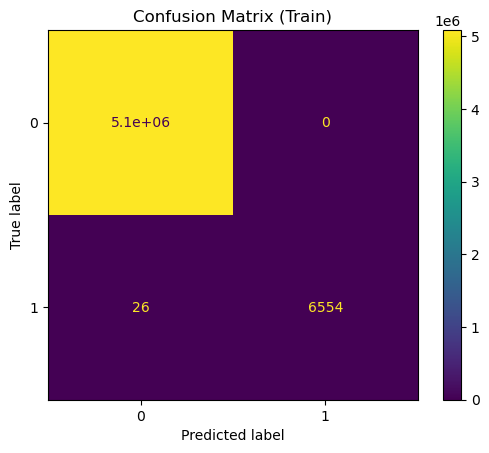

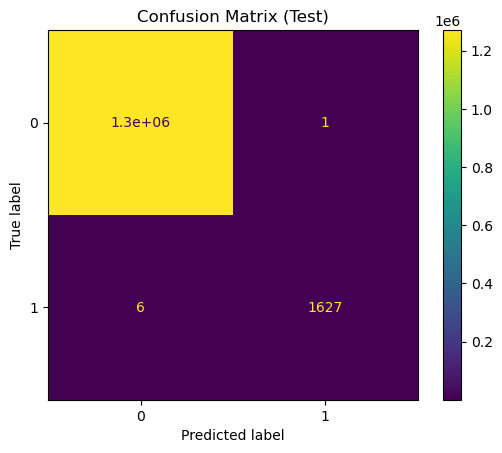

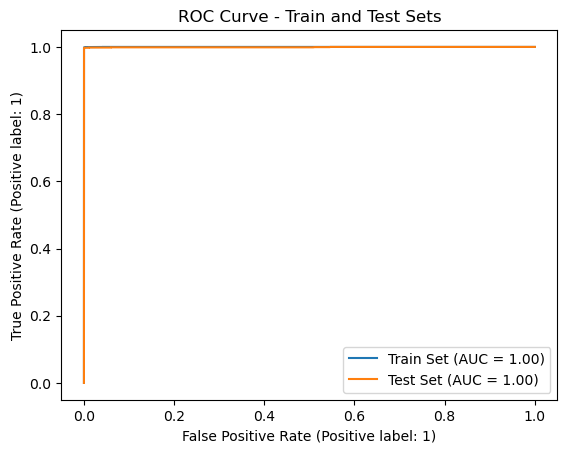

Model Lift Report (Train): 
%s    decile  response_rate   count       lift
0       1       0.012928  508992  10.000346
1       2       0.000000  509027   0.000000
2       3       0.000000  509010   0.000000
3       4       0.000000  509009   0.000000
4       5       0.000000  484743   0.000000
5       6       0.000000  515248   0.000000
6       7       0.000000  254434   0.000000
7       8       0.000000  781609   0.000000
8       9       0.000000  416431   0.000000
9      10       0.000000  601593   0.000000 

Model Lift Report (Test): 
%s    decile  response_rate   count      lift
0       1       0.012817  127253  9.987706
1       2       0.000000  127252  0.000000
2       3       0.000000  127222  0.000000
3       4       0.000000  127205  0.000000
4       5       0.000000  121788  0.000000
5       6       0.000016  128313  0.012146
6       7       0.000000   63931  0.000000
7       8       0.000000  195055  0.000000
8       9       0.000000  103362  0.000000
9      10       0.00000

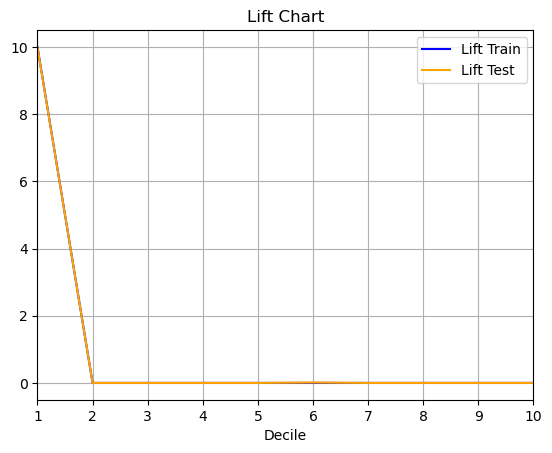

In [ ]:
eval_metrics(random_search_fit,
             train[all_columns_fit],
             train['isFraud'],
             test[all_columns_fit],
             test['isFraud'])

The Area under Precision-Recall curve is more suitable in instances where the data is severely imbalanced, as in this case.  So I would like to generate that as well, and it is not in the general function definition of the helper funcitons I have created to evaluate metrics

In [ ]:
y_pred_probs = random_search_fit.predict(test[all_columns_fit])

precision, recall, _ = precision_recall_curve( test['isFraud'], y_pred_probs)

# Calculate AUC-PR
auc_pr = auc(recall, precision)
average_precision = average_precision_score(test['isFraud'], y_pred_probs)

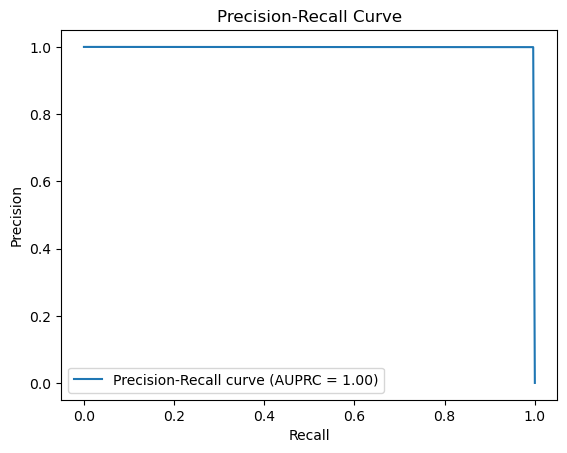

AUC-PR: 0.9978581225980544
Average Precision Score: 0.9957185020875268


In [ ]:
# Plotting the Precision-Recall curve
plt.figure()
plt.plot(recall, precision, label=f'Precision-Recall curve (AUPRC = {auc_pr:.2f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc="best")
plt.show()

print(f"AUC-PR: {auc_pr}")
print(f"Average Precision Score: {average_precision}")

Due to the large class imbalance, the fit statistics indicate an almost perfectly performing model on the test dataset.  This could be coincidence, however it could also be valid performance.  Considering that this model has barely been tuned, more investigation is needed.

I start with investigating the Shapley values of the features, to see if there is a feature that could have caused some leaking

[13:18:44] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\c_api\c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.
[13:18:45] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\c_api\c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.


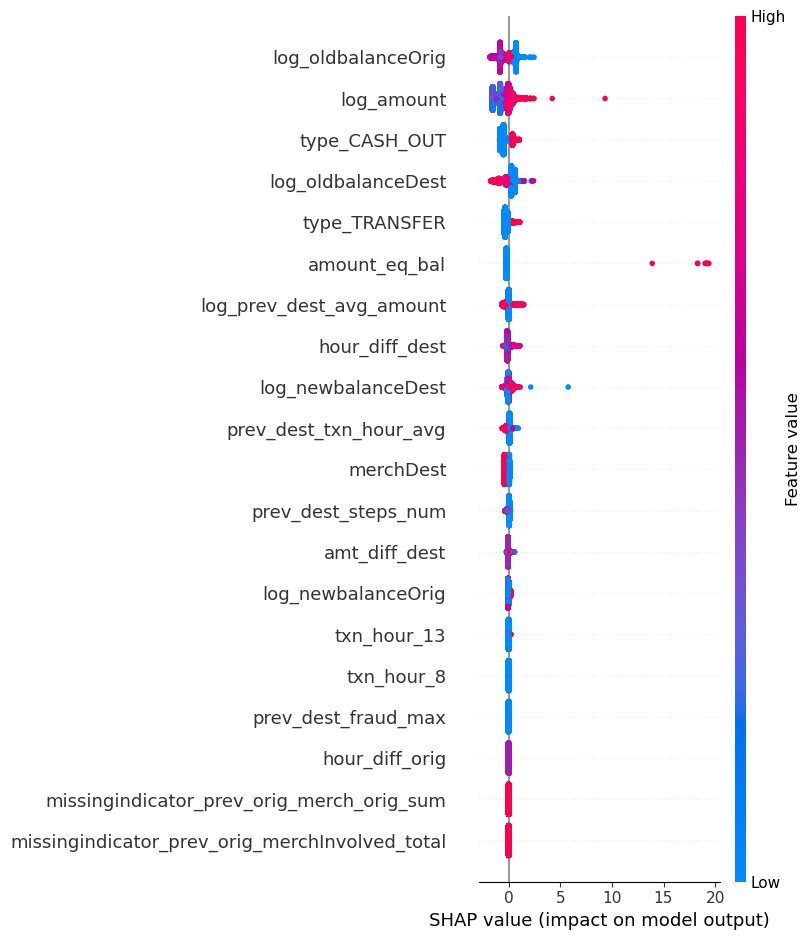

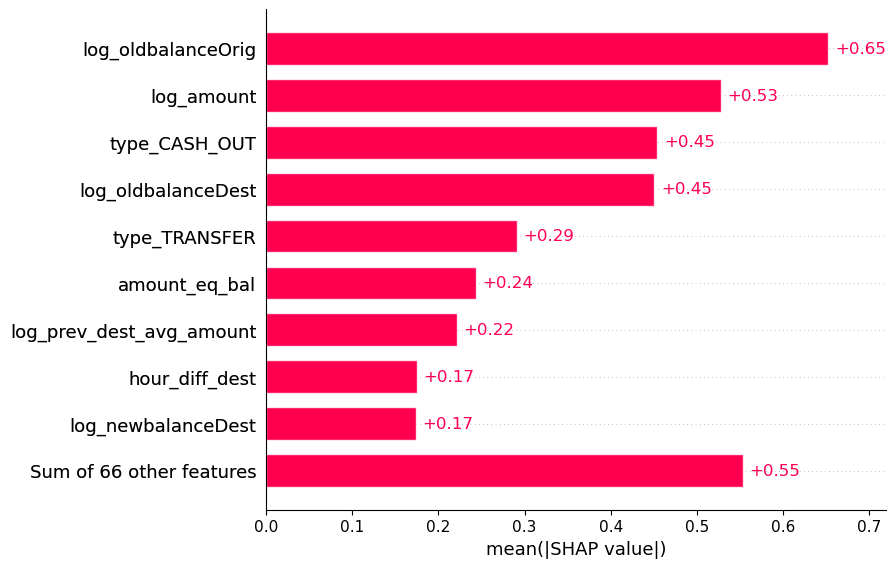

In [ ]:
plot_shap_summary_and_importance(random_search_fit.best_estimator_,
                                 test[all_columns_fit],
                                 max_display=20, random_state=123)

***Whether or not the amount is equal to the entire balance (a created feature), is the most influential feature, along with the balance of the originating account

I will still do a correleation of each of the top 4 most predictive ones, along with target distribution between the training and test set

The distribution of targets in both are similar

In [ ]:
train[['isFraud','amount_eq_bal']].corr()

,isFraud,amount_eq_bal
isFraud,1.00000,0.98906
amount_eq_bal,0.98906,1.00000


In [ ]:
train[['isFraud','amount_eq_bal']].groupby('isFraud').count()

,amount_eq_bal
isFraud,
0,5083516
1,6580
